ディジタルビームフォーミングのシミュレーション
===

In [16]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import sys

np.set_printoptions(precision=4, suppress=True, floatmode="maxprec_equal")
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,4)

In [17]:
# パラメータ
Ndata = 1000
SNRdB = 10
N_R = 4
d = np.array([[0.5]])
DOAdeg = np.array([[30]])
pointingDOAdeg = np.array([[15]])

In [18]:
# データ生成器

def rndCode(codeSize, Type):
    """
    codeSize: 生成するランダム系列の大きさ（行数ｘ列数）を指定
    Type: タイプ指定 0: [0,1], 1: [-1, 1]
    """
    
    rndCode = np.random.randn(*codeSize)
    
    if rndCode.ndim > 2:
        sys.exit()
    
    dataSize = rndCode.shape
    if len(dataSize) == 1:
        sys.exit()
    
    if Type == 0:
        rndCode = np.where(rndCode <= 0, 0, 1)
    else:
        rndCode = np.where(rndCode <= 0, -1, 1)
    
    return rndCode

# BPSK変調器
def bpskMod(data):
    """
    data: 列ベクトル
    bpskSymbol： 列ベクトル
    """
    bpskSymbol = data.copy()
    np.place(bpskSymbol, bpskSymbol == 0, -1)
    
    return bpskSymbol

In [19]:
data = rndCode([Ndata, 1], 0)
bpskSymbol = bpskMod(data)
Nsymbol = max(bpskSymbol.shape)

In [20]:
def steer(N_R, d, DOAdeg):
    """
    N_R: アンテナ数
    d: 波長で正規化したアンテナ間隔
    DOAdeg: 信号到来角度[°]
    """
    DOArad = DOAdeg * np.pi/180
    N_P = max(DOAdeg.shape)
    PSI = np.exp(-1j* 2 * np.pi * d * np.sin(DOArad))
    A = (np.ones((N_R, 1)) @ PSI) ** (np.arange(0,N_R).reshape(N_R, 1) @ np.ones((1,N_P)))
    
    return A

In [21]:
# ガウス雑音生成

def awgn(Pn, rn, cn):
    """
    Pn: 雑音電力
    ｒｎ: 行数
    cn: 列数
    """
    n = (np.random.randn(rn, cn) + 1j * np.random.randn(rn, cn)) * np.sqrt(Pn / 2)
    
    return n

In [32]:
Pn = 10**(-SNRdB/10)
steer1 = steer(N_R, d, DOAdeg)
rSig = steer1 * bpskSymbol.T + awgn(Pn, N_R, Nsymbol)

y1 = steer1.conj().T @ rSig
steer2 = steer(N_R, d, pointingDOAdeg)
y2 = steer2.conj().T @ rSig

In [33]:
def snr(s, r):
    """å
    s: SNR計算対象の信号ベクトル（x　✖️　1）
    r:　参照信号ベクトル（y　✖️　1）
    """
    length1 = max(s.shape)
    length2 = max(r.shape)
    length3 = min([length1, length2])
    coef2_tmp = np.corrcoef(s[0:length3], r[0, 0:length3], rowvar=False)
    coef2 = coef2_tmp[0,1]
    
    snr = abs(coef2) ** 2 / (1 - abs(coef2) ** 2)
    
    return snr

In [34]:
outputSNR1 = snr(bpskSymbol, y1)
outputSNR2 = snr(bpskSymbol, y2)

In [35]:
10*np.log10(outputSNR1)

15.896923125561424

In [36]:
10*np.log10(outputSNR2)

12.539338097968468

In [27]:
def antPattern(N_R, w, d):
    doa = np.arange(-90,90+1).reshape(1, 90 * 2 + 1)
    A_antPat = steer(N_R, d, doa)
    P_theta_dB = 10 * np.log10(abs(w.conj().T @ A_antPat) ** 2)
    antPat_dB = P_theta_dB - P_theta_dB.max()
    return doa, antPat_dB

In [28]:
doa, antPat_db1 = antPattern(N_R, steer1, d)
doa, antPat_db2 = antPattern(N_R, steer2, d)

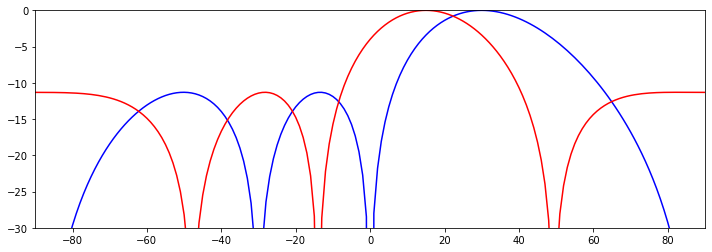

In [50]:
plt.plot(doa[0], antPat_db1[0], 'b')
plt.plot(doa[0], antPat_db2[0], 'r')
plt.xlim(-90,90)
plt.ylim(-30, 0)
plt.show();